# CAD Floor Plan Segmentation Training
# 
# This notebook trains a YOLOv11-seg model on the CAD floor plan dataset with path-based segmentation masks.


In [1]:
import os
import sys
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import cv2

# Install required packages if needed
try:
    import ultralytics
except ImportError:
    print("Installing ultralytics...")
    !pip install ultralytics
    import ultralytics

from ultralytics import YOLO
from ultralytics.utils.plotting import plot_images, plot_results


# Configuration Setup


In [2]:
# Print ultralytics version
from ultralytics import __version__ as ultralytics_version
print(f"Ultralytics version: {ultralytics_version}")

# Load the dataset config file
with open('data/cad/cad_masks.yaml', 'r') as f:
    dataset_config = yaml.safe_load(f)

print("Dataset configuration:")
for key, value in dataset_config.items():
    if key != 'names':
        print(f"  {key}: {value}")
print(f"  Classes: {len(dataset_config['names'])}")


Ultralytics version: 8.3.127
Dataset configuration:
  path: data/cad
  train: images/train-01
  val: images/train-00
  test: images/test-00
  nc: 31
  task: segment
  mask_path: masks
  format: yolo
  use_segments: True
  use_masks: True
  Classes: 31


# Prepare the dataset
# 
# Verify that our masks and images are properly set up for training.


In [3]:
# Define paths
data_path = Path(dataset_config['path'])
train_path = data_path / dataset_config['train']
val_path = data_path / dataset_config['val']
masks_path = data_path / 'masks'

# Check if train and val directories exist
print(f"Train directory exists: {train_path.exists()}")
print(f"Validation directory exists: {val_path.exists()}")
print(f"Masks directory exists: {masks_path.exists()}")

# Count files in train and validation directories
train_images = list(train_path.glob('*.png'))
val_images = list(val_path.glob('*.png'))
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")


Train directory exists: True
Validation directory exists: True
Masks directory exists: True
Number of training images: 6401
Number of validation images: 3760


# Visualize Example Images and Masks


Sample training image: data/cad/images/train-01/0682-0988.png


/tmp/ipykernel_13391/3432071509.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 32)  # 31 classes + background


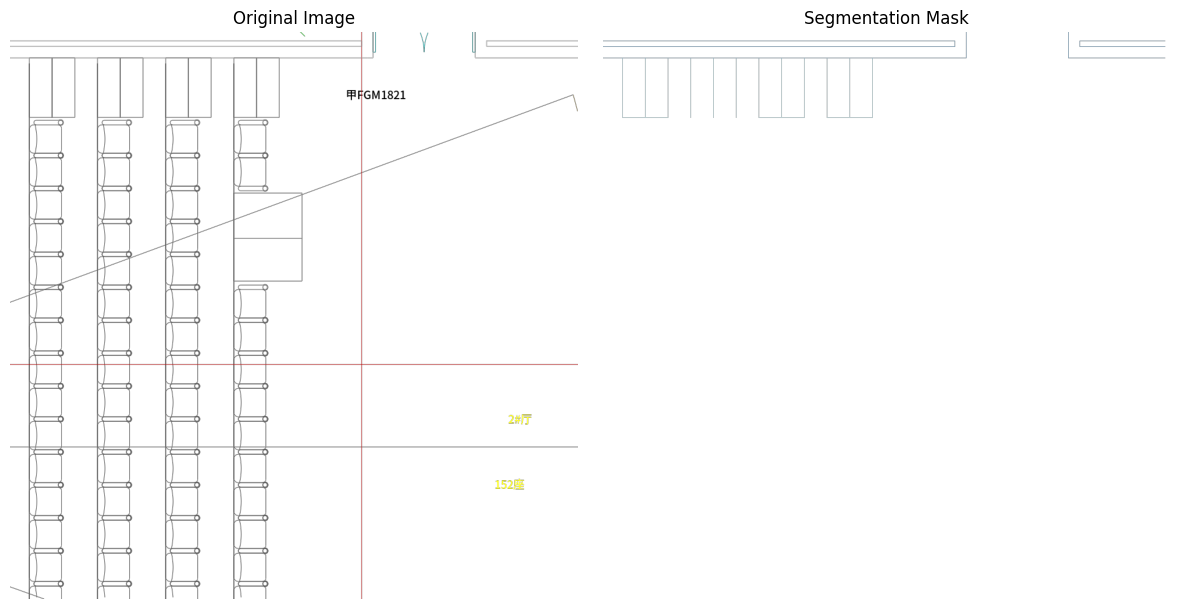

Sample validation image: data/cad/images/train-00/0400-0105.png


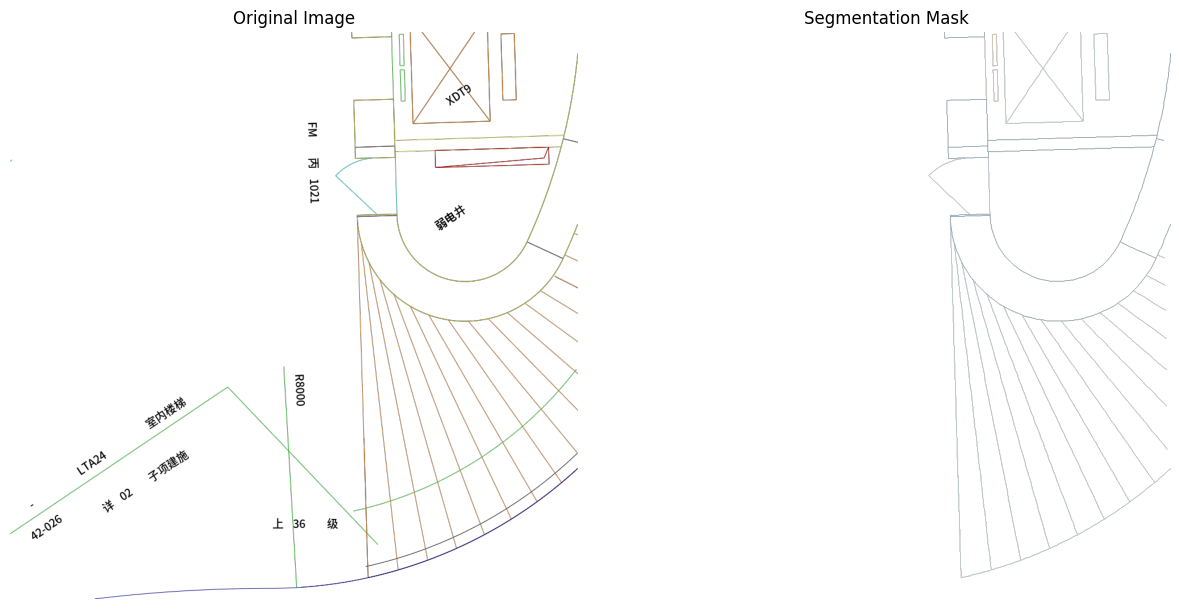

In [4]:
# Function to visualize an image and its mask
def visualize_image_and_mask(image_path, split):
    img = Image.open(image_path)
    
    # Get the mask path
    image_name = os.path.basename(image_path)
    # Remove 'images/' from split path for mask directory
    split_dir = split.replace('images/', '')
    mask_path = os.path.join(data_path, 'masks', split_dir, image_name)
    
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        # Display the image
        ax1.imshow(img)
        ax1.set_title("Original Image")
        ax1.axis('off')
        
        # Create a colormap for the mask
        cmap = plt.cm.get_cmap('tab20', 32)  # 31 classes + background
        
        # Create an RGBA mask for visualization
        mask_rgb = np.zeros((*mask.shape, 4), dtype=np.float32)
        
        # Add colors for each class
        for class_id in np.unique(mask):
            if class_id == 0:  # Skip background
                continue
            
            # Add the class color to the mask
            class_mask = (mask == class_id)
            if class_id < len(dataset_config['names']):
                class_name = dataset_config['names'][class_id]
            else:
                class_name = f"Class {class_id}"
                
            mask_rgb[class_mask] = np.array(cmap(class_id))
            
        # Add alpha channel
        mask_rgb[..., 3] = (mask > 0).astype(np.float32) * 0.7
        
        # Display the mask
        ax2.imshow(mask_rgb)
        ax2.set_title("Segmentation Mask")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Mask not found: {mask_path}")

# Visualize a sample training image and mask
if train_images:
    sample_image = train_images[0]
    print(f"Sample training image: {sample_image}")
    visualize_image_and_mask(sample_image, dataset_config['train'])
    
# Visualize a sample validation image and mask
if val_images:
    sample_image = val_images[0]
    print(f"Sample validation image: {sample_image}")
    visualize_image_and_mask(sample_image, dataset_config['val'])


# Prepare YOLO Segmentation Dataset Format


In [5]:
# Function to convert mask files to YOLO format if needed
def prepare_yolo_segmentation_dataset():
    """
    Prepare dataset files for YOLO segmentation training
    Creates symbolic links or copies masks to the expected YOLO format if necessary
    """
    print("Preparing YOLO segmentation dataset...")

    # Check if we need to create special YOLO-formatted mask directories
    train_mask_dir = os.path.join(data_path, 'masks', 'train-01')
    val_mask_dir = os.path.join(data_path, 'masks', 'train-00')
    
    # Create a special labels directory structure expected by YOLO if not using mask_path
    train_seg_dir = os.path.join(data_path, 'labels/segments/train-01')
    val_seg_dir = os.path.join(data_path, 'labels/segments/train-00')
    
    os.makedirs(train_seg_dir, exist_ok=True)
    os.makedirs(val_seg_dir, exist_ok=True)
    
    # Create a metadata file for YOLO to understand the segmentation task
    meta_dir = os.path.join(data_path, 'labels', '.meta')
    os.makedirs(meta_dir, exist_ok=True)
    
    with open(os.path.join(meta_dir, 'task.yaml'), 'w') as f:
        f.write("task: segment\n")
        f.write("mode: instances\n")
        f.write(f"nc: {dataset_config['nc']}\n")
    
    # Create a symlink or copy the masks to the segments directory for YOLO training
    # For the training set
    for img_file in os.listdir(train_mask_dir):
        if img_file.endswith('.png') and not img_file.endswith('_vis.png'):
            src = os.path.join(train_mask_dir, img_file)
            dst = os.path.join(train_seg_dir, img_file)
            
            if not os.path.exists(dst):
                # Create symlink or copy file
                try:
                    os.symlink(os.path.abspath(src), dst)
                    print(f"Created symlink from {src} to {dst}")
                except OSError:
                    # If symlink is not supported, copy the file
                    import shutil
                    shutil.copy2(src, dst)
                    print(f"Copied {src} to {dst}")
    
    # For the validation set
    for img_file in os.listdir(val_mask_dir):
        if img_file.endswith('.png') and not img_file.endswith('_vis.png'):
            src = os.path.join(val_mask_dir, img_file)
            dst = os.path.join(val_seg_dir, img_file)
            
            if not os.path.exists(dst):
                # Create symlink or copy file
                try:
                    os.symlink(os.path.abspath(src), dst)
                    print(f"Created symlink from {src} to {dst}")
                except OSError:
                    # If symlink is not supported, copy the file
                    import shutil
                    shutil.copy2(src, dst)
                    print(f"Copied {src} to {dst}")
    
    print("YOLO segmentation dataset preparation complete.")

# Run the preparation function
prepare_yolo_segmentation_dataset()


Preparing YOLO segmentation dataset...
YOLO segmentation dataset preparation complete.


# Set up and Train YOLOv11-seg Model
# 
# We'll load a pre-trained YOLOv11-seg model and fine-tune it on our CAD dataset.


In [6]:
# Define training parameters
model_name = 'yolo11l-seg.pt'  # Large YOLOv11 segmentation model
epochs = 50
batch_size = 8
image_size = 640  # Standard YOLO image size

# Download pre-trained YOLOv11 segmentation model
!pip install -U ultralytics==8.2.96


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: line 1: pip: command not found


In [7]:
# Create YOLO model
model = YOLO(model_name)
print(f"Loaded model: {model_name}")

# Check if CUDA is available
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Loaded model: yolo11l-seg.pt
CUDA available: True
GPU: NVIDIA GeForce RTX 5070 Ti


In [9]:
# Force YOLO to use our mask files by creating a new dataset structure
import yaml
import shutil
from PIL import Image
import numpy as np

# Define paths
cad_data_path = Path('data/cad')
yolo_dataset_path = Path('data/cad_yolo_segment')
train_images_dir = yolo_dataset_path / 'images' / 'train'
val_images_dir = yolo_dataset_path / 'images' / 'val'
train_labels_dir = yolo_dataset_path / 'labels' / 'train'
val_labels_dir = yolo_dataset_path / 'labels' / 'val'
train_masks_dir = yolo_dataset_path / 'masks' / 'train'
val_masks_dir = yolo_dataset_path / 'masks' / 'val'

# Create directories
for directory in [train_images_dir, val_images_dir, train_labels_dir, val_labels_dir, train_masks_dir, val_masks_dir]:
    os.makedirs(directory, exist_ok=True)

print("Created YOLO segmentation dataset structure")

# Function to create YOLO segmentation dataset
def create_yolo_segmentation_dataset():
    # Process train split
    src_train_img_dir = cad_data_path / 'images' / 'train-01'
    src_train_mask_dir = cad_data_path / 'masks' / 'train-01'
    
    # Process validation split
    src_val_img_dir = cad_data_path / 'images' / 'train-00'
    src_val_mask_dir = cad_data_path / 'masks' / 'train-00'
    
    # Function to create YOLO segmentation labels from mask
    def create_labels_from_mask(mask_path, label_path, img_path):
        # Load the mask
        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
        if mask is None:
            print(f"Failed to load mask: {mask_path}")
            return False
            
        # Get image dimensions
        img = Image.open(img_path)
        img_width, img_height = img.size
        
        # Create label file
        with open(label_path, 'w') as f:
            # Find unique class IDs in the mask (excluding background)
            class_ids = np.unique(mask)
            class_ids = class_ids[class_ids > 0]  # Remove background (0)
            
            # If no classes found, write a placeholder label for background
            if len(class_ids) == 0:
                # Background/placeholder class (class 0, one centered point, normalized coordinates)
                f.write(f"0 0.5 0.5\n")
                return True
            
            # Process each class
            for class_id in class_ids:
                if class_id <= 31:  # Valid class ID
                    # Create a binary mask for this class
                    binary_mask = (mask == class_id).astype(np.uint8)
                    
                    # Find contours in the binary mask
                    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    
                    # If no contours found, skip
                    if not contours:
                        continue
                    
                    # Find the largest contour by area
                    largest_contour = max(contours, key=cv2.contourArea)
                    
                    # If contour is too small, skip
                    if cv2.contourArea(largest_contour) < 10:  # Minimum area threshold
                        continue
                    
                    # Simplify the contour (reduce number of points)
                    epsilon = 0.005 * cv2.arcLength(largest_contour, True)
                    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
                    
                    # Ensure we have enough points
                    if len(approx) < 3:
                        continue
                    
                    # Normalize coordinates (YOLO format requires normalized coords)
                    normalized_points = []
                    for point in approx:
                        x, y = point[0]
                        normalized_points.append(f"{x/img_width} {y/img_height}")
                    
                    # Write to label file
                    # Format: class_id x1 y1 x2 y2 ... xn yn
                    f.write(f"{class_id-1} {' '.join(normalized_points)}\n")
        
        return True
    
    # Function to process a split
    def process_split(src_img_dir, src_mask_dir, dst_img_dir, dst_mask_dir, dst_labels_dir, split_name):
        print(f"Processing {split_name} split...")
        count = 0
        
        # Get list of image files
        img_files = list(src_img_dir.glob('*.png'))
        
        for img_file in tqdm(img_files, desc=f"Preparing {split_name} data"):
            img_name = img_file.name
            mask_file = src_mask_dir / img_name
            
            # Skip if mask doesn't exist
            if not mask_file.exists():
                continue
                
            # Copy image to destination
            dst_img_file = dst_img_dir / img_name
            shutil.copy2(img_file, dst_img_file)
            
            # Copy mask to destination
            dst_mask_file = dst_mask_dir / img_name
            shutil.copy2(mask_file, dst_mask_file)
            
            # Create label file with segmentation information
            label_file = dst_labels_dir / (img_file.stem + '.txt')
            if create_labels_from_mask(mask_file, label_file, img_file):
                count += 1
        
        print(f"Processed {count} images for {split_name}")
        return count
    
    # Process both splits
    train_count = process_split(src_train_img_dir, src_train_mask_dir, train_images_dir, train_masks_dir, train_labels_dir, "train")
    val_count = process_split(src_val_img_dir, src_val_mask_dir, val_images_dir, val_masks_dir, val_labels_dir, "val")
    
    return train_count, val_count

# Create the dataset
train_count, val_count = create_yolo_segmentation_dataset()

# Create dataset.yaml file
custom_dataset = {
    'path': str(yolo_dataset_path.absolute()),
    'train': 'images/train',
    'val': 'images/val',
    'nc': 31,
    'names': dataset_config['names'],
    'task': 'segment',
    'mask_path': 'masks',
    'format': 'yolo',
}

# Write to a temporary file
custom_yaml_path = str(yolo_dataset_path / 'dataset.yaml')
with open(custom_yaml_path, 'w') as f:
    yaml.dump(custom_dataset, f, default_flow_style=False)

print("Created custom dataset configuration:")
with open(custom_yaml_path, 'r') as f:
    print(f.read())

# Remove any cached labels to force YOLO to use our masks
for cache_file in Path('data').glob('**/labels/*.cache'):
    try:
        cache_file.unlink()
        print(f"Removed cache file: {cache_file}")
    except:
        print(f"Failed to remove cache file: {cache_file}")

# Update the YAML configuration to ensure it has the right settings for semantic segmentation
with open(custom_yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)
    
yaml_content.update({
    'task': 'segment',
    'mode': 'instance',
    'use_segments': True,
    'use_masks': True
})

# Write the updated YAML back
with open(custom_yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print("Updated YAML configuration for semantic segmentation:")
with open(custom_yaml_path, 'r') as f:
    print(f.read())

# Start training with semantic segmentation parameters
results = model.train(
    data=custom_yaml_path,
    epochs=epochs,
    batch=batch_size,
    imgsz=image_size,
    save=True,              # Save checkpoints
    device=0,               # Use GPU if available
    patience=10,            # Early stopping patience
    optimizer='AdamW',      # Optimizer
    lr0=1e-3,               # Initial learning rate
    lrf=1e-4,               # Final learning rate
    dropout=0.0,            # Dropout rate
    mosaic=0.0,             # Disable mosaic augmentation for fine details
    project='runs/train',   # Project name
    name='yolov11l_cad_seg',# Experiment name
    exist_ok=True,          # Overwrite if exists
    task='segment',         # Explicitly set task to segment
    mask_ratio=4,           # Mask downsample ratio
    overlap_mask=True,      # Overlapping masks
    single_cls=False,       # Multiple classes
    cache=False,            # Disable caching to force use of our masks
    rect=False,             # No rectangular training
    resume=False,           # Don't resume from previous run
    verbose=True            # Show detailed training information
)


Created YOLO segmentation dataset structure
Processing train split...


NameError: name 'tqdm' is not defined

# Evaluate the Model


In [16]:
# Run validation
val_results = model.val(data='data/cad/cad_masks.yaml')
print(f"Validation results: {val_results}")

# Plot training results
results.plot()


Ultralytics 8.3.127 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
YOLO11l-seg summary (fused): 203 layers, 27,608,493 parameters, 305,021 gradients, 142.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 573.6±180.3 MB/s, size: 83.7 KB)


val: Scanning /home/ubuntu/floor-plan-net/data/cad/labels/train-00.cache... 2903 images, 857 backgrounds, 0 corrupt: 100%|██████████| 3760/3760 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/235 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 1/235 [00:01<04:17,  1.10s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   1%|          | 2/235 [00:01<02:39,  1.46it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  14%|█▍        | 34/235 [00:08<00:48,  4.16it/s]


KeyboardInterrupt: 

# Test on Sample Image


Detailed analysis of sample: 0400-0105.png

Saving runs/segment/predict5/0400-01052/stage0_Conv_features.png... (32/64)
Saving runs/segment/predict5/0400-01052/stage1_Conv_features.png... (32/128)
Saving runs/segment/predict5/0400-01052/stage2_C3k2_features.png... (32/256)
Saving runs/segment/predict5/0400-01052/stage3_Conv_features.png... (32/256)
Saving runs/segment/predict5/0400-01052/stage4_C3k2_features.png... (32/512)
Saving runs/segment/predict5/0400-01052/stage5_Conv_features.png... (32/512)
Saving runs/segment/predict5/0400-01052/stage6_C3k2_features.png... (32/512)
Saving runs/segment/predict5/0400-01052/stage7_Conv_features.png... (32/512)
Saving runs/segment/predict5/0400-01052/stage8_C3k2_features.png... (32/512)
Saving runs/segment/predict5/0400-01052/stage9_SPPF_features.png... (32/512)
Saving runs/segment/predict5/0400-01052/stage10_C2PSA_features.png... (32/512)
Saving runs/segment/predict5/0400-01052/stage11_Upsample_features.png... (32/512)
Saving runs/segment/predic

/tmp/ipykernel_6138/373746460.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(class_names))


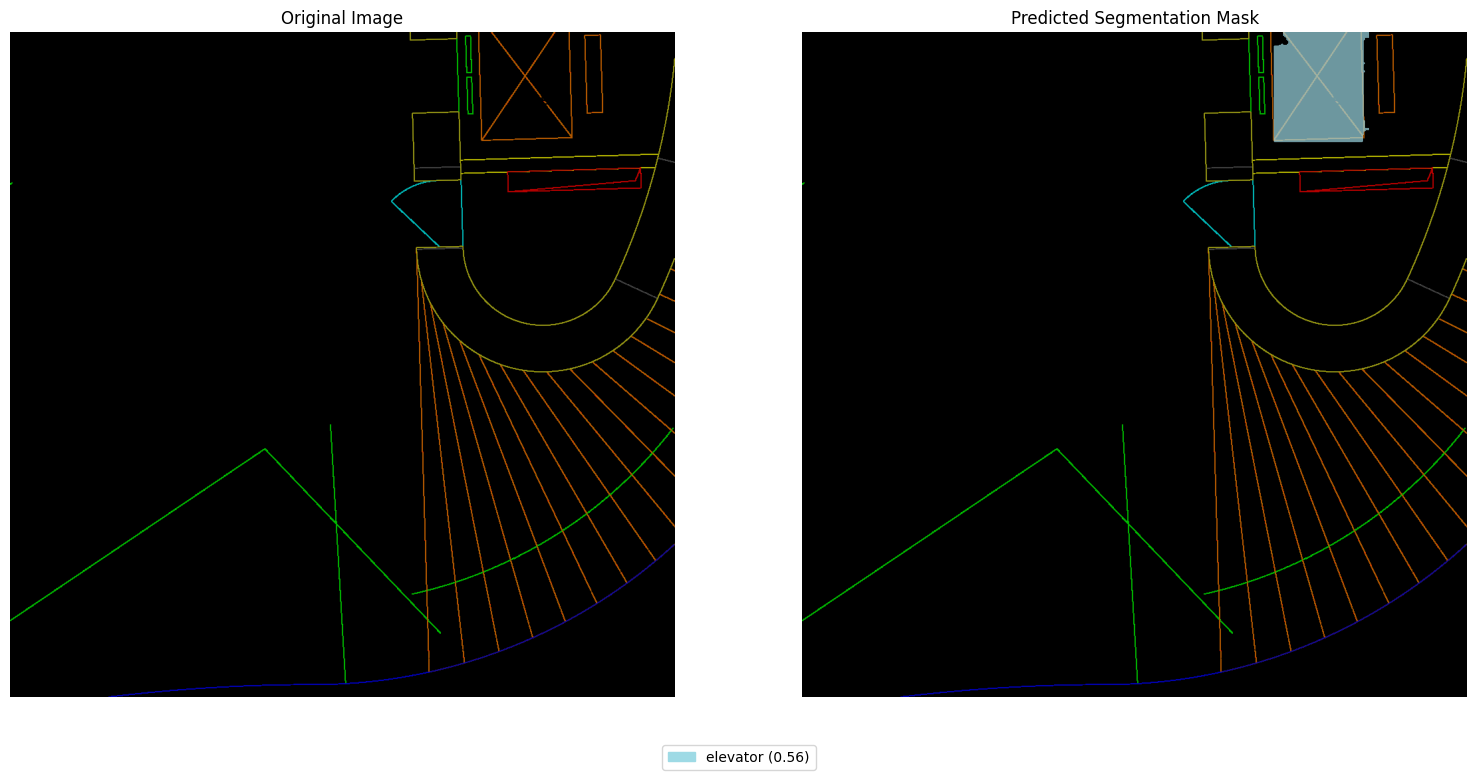

Classes found in the image: elevator


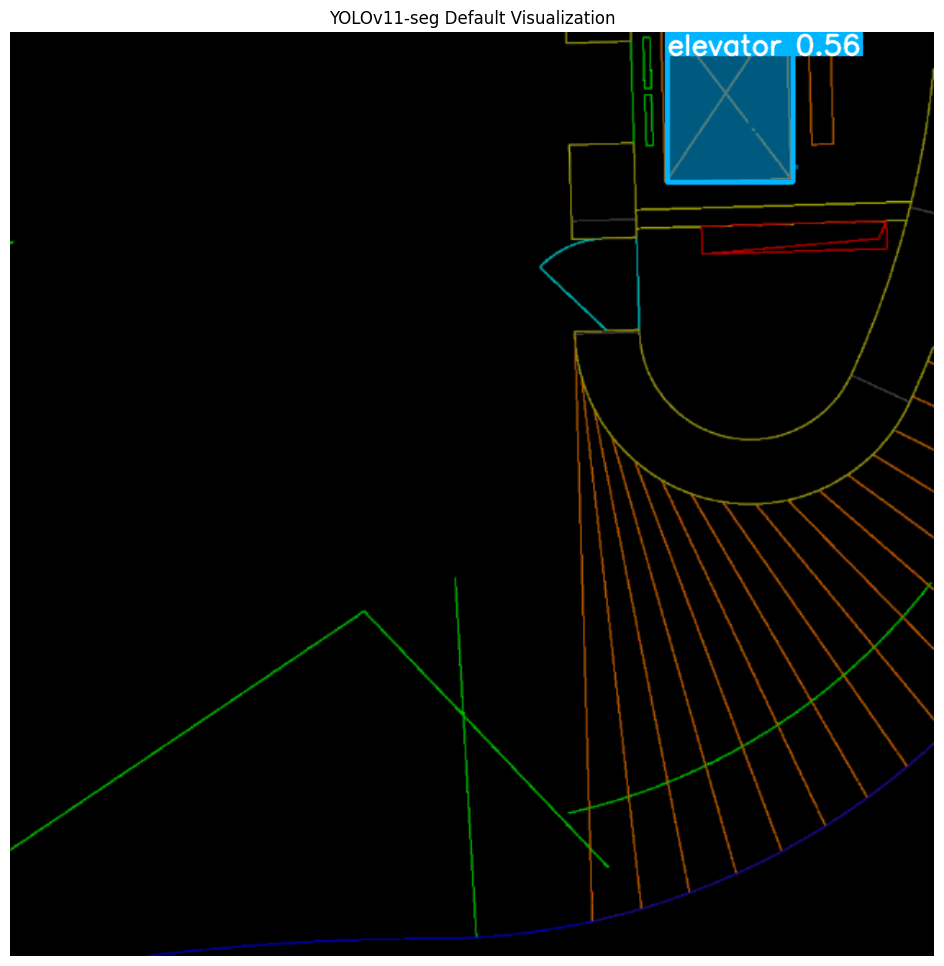

In [52]:
# Define a function to visualize multiple samples
def visualize_sample_predictions(model, image_paths, conf=0.25, max_samples=3):
    """
    Run inference on multiple sample images and visualize the results
    
    Args:
        model: The YOLO model
        image_paths: List of image paths to predict on
        conf: Confidence threshold
        max_samples: Maximum number of samples to visualize
    """
    samples = min(max_samples, len(image_paths))
    for i in range(samples):
        sample_image = str(image_paths[i])
        print(f"\nSample {i+1}/{samples}: {os.path.basename(sample_image)}")
        
        # Run model prediction
        results = model.predict(
            source=sample_image,
            conf=conf,            # Confidence threshold
            iou=0.45,             # IoU threshold
            max_det=100,          # Maximum detections
            save=False,           # Don't save results
            visualize=False       # Don't visualize results
        )
        
        # Visualize the masks
        classes_found = visualize_segmentation_masks(results, sample_image, dataset_config['names'])
        if classes_found:
            class_list = ', '.join([f"{name} ({conf:.2f})" for _, name, conf in classes_found])
            print(f"Classes detected: {class_list}")
        else:
            print("No objects detected.")

# Run inference on sample images
if val_images:
    # Select random samples
    import random
    random.seed(42)  # For reproducibility
    sample_indices = random.sample(range(len(val_images)), min(5, len(val_images)))
    sample_images = [str(val_images[i]) for i in sample_indices]
    
    # Run inference on a single sample for detailed visualization
    sample_image = str(val_images[0])
    print(f"Detailed analysis of sample: {os.path.basename(sample_image)}")
    results = model.predict(
        source=sample_image,
        conf=0.25,          # Confidence threshold
        iou=0.45,           # IoU threshold
        max_det=100,        # Maximum detections
        save=True,          # Save results
        visualize=True      # Visualize results
    )
    
    # Create a function to visualize just the segmentation masks
    def visualize_segmentation_masks(results, original_image_path, class_names):
        """
        Visualize just the segmentation masks from YOLO results
        
        Args:
            results: The YOLO results object
            original_image_path: Path to the original image
            class_names: List of class names
        """
        # Load the original image
        original_img = cv2.imread(original_image_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # Get image dimensions
        img_height, img_width = original_img.shape[:2]
        
        # Create an empty mask to hold all segmentation results
        combined_mask = np.zeros((img_height, img_width, 4), dtype=np.float32)
        
        # Get a colormap with distinct colors
        cmap = plt.cm.get_cmap('tab20', len(class_names))
        
        # Keep track of classes found in the image
        classes_found = []
        
        # Process each detection
        if hasattr(results[0], 'masks') and results[0].masks is not None:
            # Process each mask
            for i, mask in enumerate(results[0].masks.data):
                # Get class id and confidence
                class_id = int(results[0].boxes.cls[i].item())
                conf = results[0].boxes.conf[i].item()
                
                # Get class name
                if class_id < len(class_names):
                    class_name = class_names[class_id]
                else:
                    class_name = f"Class {class_id}"
                
                # Add to found classes
                classes_found.append((class_id, class_name, conf))
                
                # Convert mask to numpy array
                mask_np = mask.cpu().numpy()
                
                # Resize mask to match image dimensions
                if mask_np.shape[:2] != (img_height, img_width):
                    mask_np = cv2.resize(mask_np, (img_width, img_height))
                
                # Create a color for this mask with alpha channel
                color = np.array(cmap(class_id))
                
                # Create a colored mask for this class
                colored_mask = np.zeros((img_height, img_width, 4), dtype=np.float32)
                colored_mask[mask_np > 0.5] = color
                
                # Add the mask to the combined mask (with transparency)
                alpha = 0.7  # Transparency level
                colored_mask[..., 3] = (mask_np > 0.5) * alpha
                
                # Composite this mask onto the combined mask
                # Areas where combined_mask has no opacity, use colored_mask
                # Areas where both have opacity, blend them
                combined_mask = np.where(
                    combined_mask[..., 3:4] == 0,
                    colored_mask,
                    combined_mask * (1 - colored_mask[..., 3:4]) + colored_mask * colored_mask[..., 3:4]
                )
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Plot original image
        ax1.imshow(original_img)
        ax1.set_title("Original Image")
        ax1.axis('off')
        
        # Plot segmentation mask
        ax2.imshow(original_img)  # First show the original image
        ax2.imshow(combined_mask)  # Then overlay the mask
        ax2.set_title("Predicted Segmentation Mask")
        ax2.axis('off')
        
        # Create a legend for classes found
        handles = []
        labels = []
        for class_id, class_name, conf in sorted(classes_found):
            patch = plt.Rectangle((0, 0), 1, 1, color=cmap(class_id))
            handles.append(patch)
            labels.append(f"{class_name} ({conf:.2f})")
        
        # Add legend below the figure
        if handles:
            fig.legend(handles, labels, loc='lower center', ncol=min(5, len(handles)), 
                      bbox_to_anchor=(0.5, 0.05))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)  # Make room for the legend
        plt.show()
        
        # Return the classes found
        return classes_found
    
    # Display just the segmentation masks
    classes_found = visualize_segmentation_masks(results, sample_image, dataset_config['names'])
    print(f"Classes found in the image: {', '.join([name for _, name, _ in classes_found])}")
    
    # Also show the default visualization for comparison
    plt.figure(figsize=(12, 12))
    result_img = results[0].plot()
    plt.imshow(result_img[..., ::-1])  # Convert BGR to RGB
    plt.axis('off')
    plt.title('YOLOv11-seg Default Visualization')
    plt.show()


# Export the Model


In [ ]:
# Export the model for deployment
export_format = 'onnx'  # Options: onnx, torchscript, openvino
model.export(format=export_format)
print(f"Model exported to {export_format} format")


# Conclusion
# 
# We have successfully trained a YOLOv11-seg model on our CAD floor plan dataset 
# with path-based segmentation masks. The model can now identify and segment
# different architectural elements in floor plans.
#
# Next steps:
# 1. Try different model architectures (yolov11n-seg, yolov11m-seg)
# 2. Experiment with different training configurations
# 3. Apply the model to new floor plans